In [33]:
# 필요 라이브러리 임포트

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [34]:
# GPU 사용환경 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
# 데이터 가져오기

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         shuffle_files = True, 
                                         with_info = True)

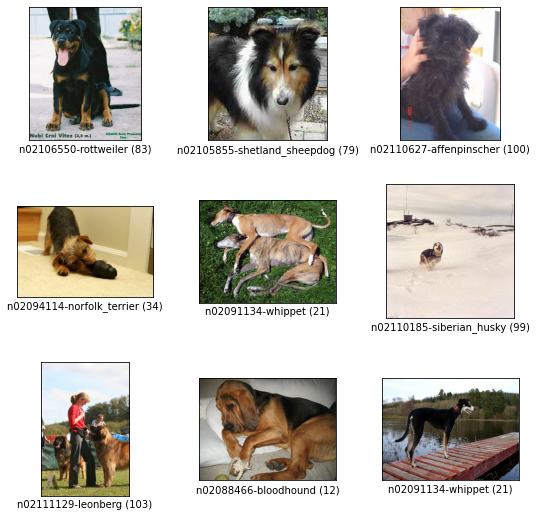

In [36]:
# 데이터 샘플 살펴보기

fig = tfds.show_examples(ds_train, ds_info)

In [37]:
# augmentation 적용을 위한 전처리 함수

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [38]:
# random_augmentation 중 random_flip_left_right() 와 random_brightness() 적용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [39]:
# 위에서 구현한 함수를 통해 배치 단위의 CutMix 함수 구현

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

In [40]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix,num_parallel_calls = 2)
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [41]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

# keras 의 ResNet50 중 imagenet 에 훈련도니 모델을 불러온다.
# include_top 은 마지막 fully connected layer 를 포함할지 여부
# 해당 레이어를 포함하지 않고 생성하면 feature extractor (특성 추출기) 부분만 불러와 
# 필요에 맞게 수정된 fully connected layer 를 붙여 활용 가능
# imagemet 과 테스트셋이 서로 다른 클래스를 가지기 때문에
# 마지막에 추가해야하는 fully connect layer 의 구조 (뉴런의 개수) 또한 다르다.

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

In [42]:
# Augmentation 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [43]:
# 텐서플로우 데이터에서 불러온 데이터에 apply_normalize_on_dataset() 에
# 하나는 with_aug 를 False 로,
# 다른 하나는 with_aug 를 True 로 설정

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

NameError: name 'onehot' is not defined

In [ ]:
# 각 각의 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

In [ ]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()